# Supervised Learning Project 2: Kickstarter Data Classification 

In [84]:
from IPython.core.display import display, HTML
display(HTML('<style>.container{ width:100% !important; }</style>'))

In [2]:
# munging imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

### Import Kickstarter Data


The Kickstarter Dataset is a webscraped csv file that is taken from Kaggle. First, import the data, and then drop unnecessary columns. Clean up columns names before taking a look at the dataset.

In [4]:
data=pd.read_csv('ks-projects-201612.csv', encoding='latin_1',index_col=1)

pd.options.display.max_rows=1000

/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The original dataset contains 323750 observations and 12 usable features. First drop the extraneous features. 

In [5]:
dataset=data.drop(columns=['Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16','currency ','ID ','launched ']).reset_index()
dataset.columns=dataset.columns.str.replace(' ', '').get_level_values(0)
dataset.shape


(323750, 10)

In [83]:
dataset.head()

,name,category,main_category,deadline,goal,pledged,state,backers,country,usdpledged
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09 11:36:00,1000,0,failed,0,GB,0
1,Where is Hank?,Narrative Film,Film & Video,2013-02-26 00:20:50,45000,220,failed,3,US,220
2,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16 04:24:11,5000,1,failed,1,US,1
3,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,2015-08-29 01:00:00,19500,1283,canceled,14,US,1283
4,Monarch Espresso Bar,Restaurants,Food,2016-04-01 13:38:27,50000,52375,successful,224,US,52375


## 1. Clean the Data

#### Since the goal is to classify whether a company succeeded or failed their kickstarter campaign, let's start by taking a look at the number of unique targets. 

After some data exploration, it appears there are 323118 observations that have correctly labeled targets, in the classes of "successful", "failed", "suspended", "canceled", or "live" (632 mislabeled targets). 

I further explored the 632 rows of mislabeled data, and found a good majority of the data had some variation of missing data, which explained why the columns were shifted. Before eliminating these observations, I explored whether this group of data had a balanced distribution of features and targets, as to avoid skewing the overall dataset. It appeared that the number of "successful" to "failed" ratio in the group is 167 to 386, with the remaining 79 targets populating the other three classes. The categories of these mislabeled observations are scattered as well, with no obvious biases. The best approach would be to re-align these mislabeled columns and fill in missing data by further research in order to not lose data, but under the tight deadline of this project, I eliminated these rows of data after determining there will be no significant bias or data scarsity imposed on the original dataset. 

In [6]:
dataset.groupby('state').count()

data_class = dataset.loc[dataset['state'].isin(['canceled','failed','live','successful','suspended','undefined'])]
data_dropped = dataset.drop(data_class.index)

print('State = "failed" in mislabeled observations is {}'.format(len(data_dropped[(data_dropped['backers']=='failed')
                       |(data_dropped['country']=='failed')
                       |(data_dropped['usdpledged']=='failed')])))
                        
print('State = "successful" in mislabeled observations is {}'.format(len(data_dropped[(data_dropped['backers']=='successful')
                       |(data_dropped['country']=='successful')
                       |(data_dropped['usdpledged']=='successful')])))

print('State = "failed" in original observations is {}'.format(len(dataset[dataset['state']=='failed'])))
print('State = "successful" in mislabeled observations is {}'.format(len(dataset[dataset['state']=='successful'])))


State = "failed" in mislabeled observations is 386
State = "successful" in mislabeled observations is 167
State = "failed" in original observations is 168221
State = "successful" in mislabeled observations is 113081


#### Next, let's take a look at the current features, first at the categorical features (main category and country), then the numerical features.  

It is beneficial to look at the distribution of the features to get an idea of the data at hand, which can become very useful when interpreting the model metrics. A large portion of the projects are based in the US, and main categories of kickstarter projects are in "Film & Video", "Music", "Publishing", "Technology", and "Games". 

In the country graph, notice there is a country labeled as "N,"0'". Upon researching these projects, many are not found on the internet, and the ones that are found have multiple information that are missing from the page, or have page access restricts. Once again for the purposes of this project, I took a look at the features of this sample and eliminated these observations after determining that the original dataset would not be skewed.

Before moving onto the numerical features, I used various pandas functionalities to make sure that all the categories and countries are appropriately filled in.

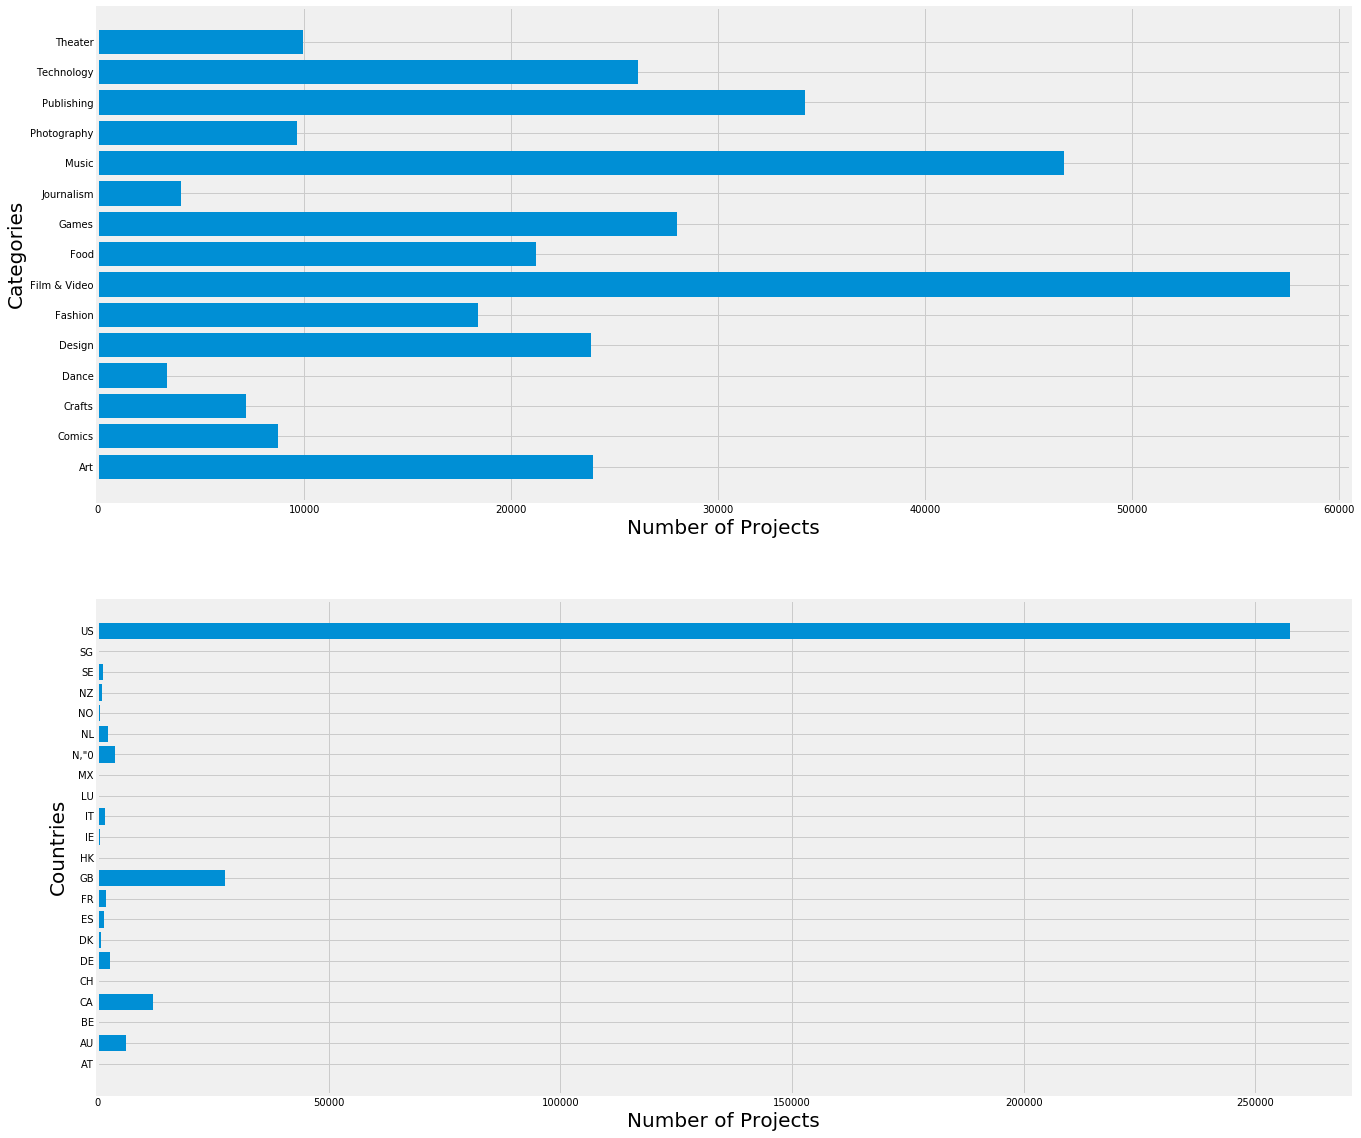

In [7]:
#pd.DataFrame(np.array(data_class.groupby('main_category').count().index.unique()),columns=['main_categories'])

main_category=data_class.groupby('main_category').count()
country=data_class.groupby('country').count()

plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
plt.barh(main_category.index, main_category.name)
plt.xlabel('Number of Projects', size=20)
plt.ylabel('Categories', size=20)

plt.subplot(2,1,2)
plt.barh(country.index, country.name)
plt.xlabel('Number of Projects', size=20)
plt.ylabel('Countries', size=20)

# drop countries with [N,"0'] 

country_drop=data_class[data_class['country']=='N,"0'].index
data_class=data_class.drop(country_drop)

#### Next, let's clean and convert the numerical features.

Currently, everything in the dataframe is an object. A simple way to catch mislabeling is converting objects to numbers. An error will occur if the value in the column doesn't not obey the format of a numeric or datetime, and the error message can be used to identify the row that is causing the problem. By using this method, I cleaned the dataframe further, and converted numerical objects to the appropriate type. 

In [8]:
data_class['deadline']= pd.to_datetime(data_class['deadline']) 
data_class.goal=pd.to_numeric(data_class.goal).astype(np.int64)
data_class.backers=pd.to_numeric(data_class.backers).astype(np.int64)
data_class.pledged=pd.to_numeric(data_class.pledged).astype(np.int64)
data_class.usdpledged=pd.to_numeric(data_class.usdpledged).fillna(0).astype(np.int64)

#### Now that we have a clean dataframe (data_class)...... 

For the purposes of a preliminary analysis, I dropped the following columns:
* category: this is meant to be added back in later after preliminary analysis
* usdpledged: this is a repeat of the "pledged" column
* deadline: year doesn't seem to be an important feature in determining the success or failure of a campaign, though can add in later to seek trends in a certain category. 

For most people who are interested in this dataset to predict outcome, they want to know is whether a campaign succeeds or fails, and not so much about whether it would be canceled, suspended, or 'live' (meaning it is still going on). Therefore, the targets are classified into a binary classes, with "canceled", "suspended", and "live" that performed below average success amount all labeled as "failed". Targets that were "live" and pledged above the success average rate were labeled as successful.

In [9]:
data_class.groupby('state').mean()

,goal,pledged,backers,usdpledged
state,,,,
canceled,88041.605128,2287.607386,25.194946,2032.942379
failed,63501.076525,1369.380422,16.781704,1280.301738
live,64125.405692,11778.938559,80.348317,2985.921391
successful,9627.802746,21480.659777,253.860041,19456.967436
suspended,217738.423832,10478.654028,114.007448,9202.291808


In [10]:
clean_data_binary=data_class.copy().reset_index()

In [ ]:
mask_canceled=clean_data_binary.loc[clean_data_binary['state']=='canceled'] 
mask_suspended=clean_data_binary.loc[clean_data_binary['state']=='suspended']
mask_live_success=clean_data_binary[(clean_data_binary['state']=='live') & (clean_data_binary['pledged']>21480.659777)]
mask_live_failed=clean_data_binary[(clean_data_binary['state']=='live') & (clean_data_binary['pledged']<=21480.659777)]
mask_canceled['state']='failed'
mask_suspended['state']='failed'
mask_live_success['state']='successful'
mask_live_failed['state']='failed'
mask_binary=clean_data_binary[(clean_data_binary['state']=='failed') | (clean_data_binary['state']=='successful')]

In [12]:
clean_binary=pd.concat([mask_binary, mask_canceled, mask_suspended, mask_live_success, mask_live_failed]).sort_values(
    by='index').reset_index().drop(columns=['index','level_0','deadline','usdpledged'])

In [13]:
print(len(clean_binary.loc[clean_binary['state']=='successful']))
print(len(clean_binary.loc[clean_binary['state']=='failed']))

113315
206013


In [14]:
clean_binary.to_csv('clean_binary.csv')

## 2. First Round Models

With the clean dataset, I ran first round of models to get an idea of how the current dataset performs. For experimental purposes, I selected a random 20% sample of the dataset to speed up the modeling (sample_20), and dropped the subcategories columns to decrease the number of dummy variables. Most importantly, drop the pledged column since the target was created by calculating whether the pledged amount met the goal of the campaign. 

**Models Used in first round:**
* Logistic Regression
* KNN
* Decision Tree
* Random Forest
* Gradient Boosting Tree
* SVM 

In [86]:
# Sample 20% of entire dataset for these first round models. First, get dummies for categorical features. 

sample_20 = clean_binary.sample(frac=0.2,random_state=42).drop(columns=['name', 'category'])
len(sample_20)

sample_20_dummies=pd.get_dummies(sample_20, drop_first=True)

sample_20_dummies=sample_20_dummies[['goal', 'backers', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ',
       'country_SE', 'country_SG', 'country_US','state_successful']]

In [87]:
# Set up variables and train_test_split for modeling.

y=sample_20_dummies.state_successful
X=sample_20_dummies.iloc[:, :-1]


Xtrain, X_test, ytrain, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Scale for regression models

scaler=StandardScaler()

X_scaled = scaler.fit_transform(Xtrain.values)
X_test_scaled = scaler.fit_transform(X_test.values)

### Logistic Regression 

/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6433380303741976
0.5013014065734899


Text(0.5, 1.0, 'Logistic regression confusion matrix')

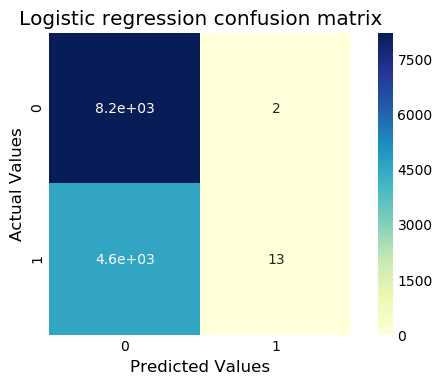

In [20]:
logreg_cv=LogisticRegressionCV()
logreg_cv.fit(X_scaled, ytrain)
print(logreg_cv.score(X_test,y_test))

y_pred_log=logreg_cv.predict(X_test)
confusion_log=confusion_matrix(y_test, y_pred_log)

plt.figure(dpi=100)
sns.heatmap(confusion_log, cmap=plt.cm.YlGnBu, annot=True, square=True)
print(roc_auc_score(y_test, y_pred_log))

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic regression confusion matrix')

### KNN Model

0.6445905746046657
0.5031502184458632


Text(0.5, 1.0, 'KNN confusion matrix')

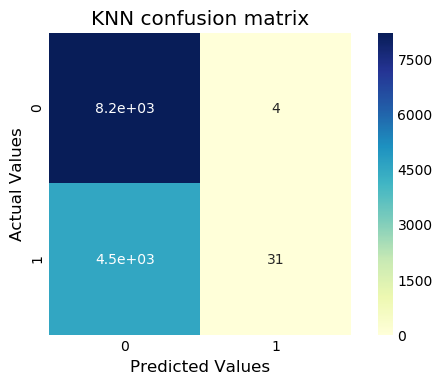

In [21]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_scaled, ytrain)
print(knn.score(X_test, y_test))

y_pred_knn=knn.predict(X_test)
confusion_knn=confusion_matrix(y_test, y_pred_knn)

print(roc_auc_score(y_test, y_pred_knn))

plt.figure(dpi=100)
sns.heatmap(confusion_knn, cmap=plt.cm.YlGnBu, annot=True, square=True)

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('KNN confusion matrix')

### ROC Curve for Logistic Regression and KNN

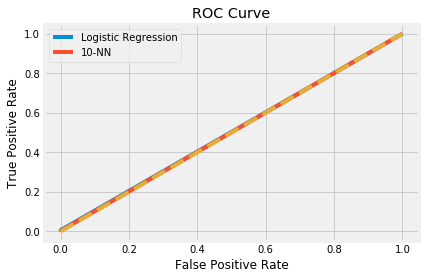

In [22]:
from sklearn.metrics import roc_curve

#fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
fpr, tpr, _ = roc_curve(y_test, y_pred_knn)
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, y_pred_log)
plt.plot(fpr, tpr)

x = np.linspace(0,1,100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression','10-NN'])

 
### Decision Tree Classifier

0.904650070455613
0.8952038544803419


Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

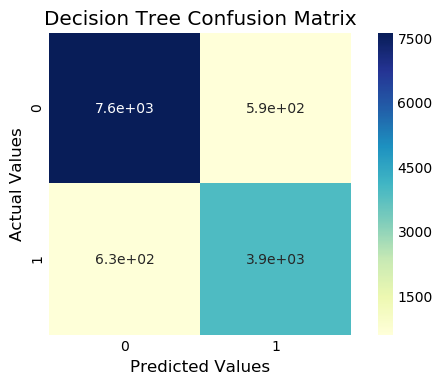

In [23]:
dct=DecisionTreeClassifier()

dct.fit(Xtrain,ytrain)

print(dct.score(X_test, y_test))


y_pred_dct=dct.predict(X_test)
print(roc_auc_score(y_test, y_pred_dct))

confusion_dct=confusion_matrix(y_test, y_pred_dct)

plt.figure(dpi=100)
sns.heatmap(confusion_dct, cmap=plt.cm.YlGnBu, annot=True, square=True)


plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Decision Tree Confusion Matrix')

### Random Forest

Decision Tree has performed very well given that there was no bootstrapping happening. Try Random Forest

0.9253485778494377
0.9307186472522311


Text(0.5, 1.0, 'Random Forest Classifier confusion matrix')

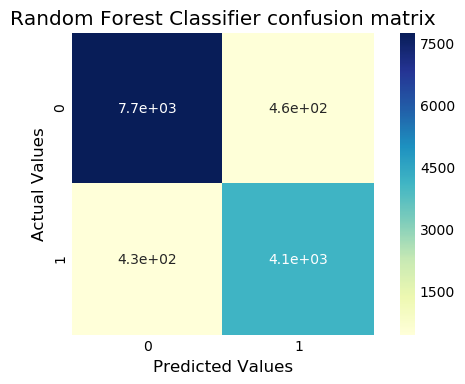

In [24]:
rfmodel1 = RandomForestClassifier(n_estimators = 500, min_samples_leaf=5, max_features=4, n_jobs=-1)
rfmodel1.fit(Xtrain,ytrain)

rfreg1 = RandomForestRegressor(n_estimators = 500, min_samples_leaf=5, max_features=4, n_jobs=-1)
rfreg1.fit(Xtrain,ytrain)

y_pred_rfc= rfmodel1.predict(X_test)
y_pred_rfg= rfreg1.predict(X_test)

print(roc_auc_score(y_test,y_pred_rfc))
print(rfmodel1.score(X_test, y_test))

confusion_rfc=confusion_matrix(y_test, y_pred_rfc)


plt.figure(dpi=100)
sns.heatmap(confusion_rfc, cmap=plt.cm.YlGnBu, annot=True, square=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Random Forest Classifier confusion matrix')

### Gradient Boosting Tree

0.9355722561452952
0.9334474549208702


Text(0.5, 1.0, 'Gradient Boosting confusion matrix')

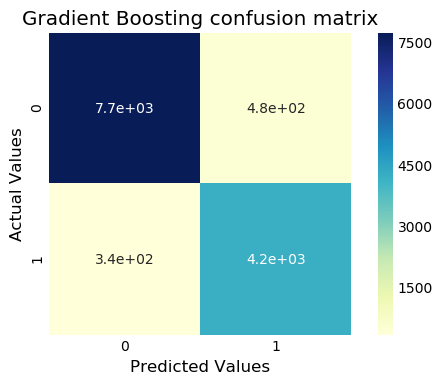

In [25]:
gbm = XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(Xtrain,ytrain),(X_test,y_test)]
fit_model = gbm.fit( 
                    Xtrain, ytrain, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

y_pred_xgb= gbm.predict(X_test)
confusion_xgb = confusion_matrix(y_test, y_pred_xgb)
print(gbm.score(X_test, y_test))
print(roc_auc_score(y_test, y_pred_xgb))
plt.figure(dpi=100)
sns.heatmap(confusion_xgb, cmap=plt.cm.YlGnBu, annot=True, square=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Gradient Boosting confusion matrix')

In [45]:
gbm.feature_importances_

array([0.1097449 , 0.36507723, 0.02080716, 0.00716465, 0.02647521,
       0.0410764 , 0.01726589, 0.03959427, 0.00622747, 0.05880604,
       0.00234487, 0.05057199, 0.00319245, 0.01088557, 0.03613256,
       0.03967464, 0.00249371, 0.        , 0.00751157, 0.        ,
       0.00936843, 0.01647183, 0.00947167, 0.        , 0.01925126,
       0.        , 0.        , 0.00982065, 0.        , 0.01616409,
       0.00611515, 0.02140603, 0.01084368, 0.02338238, 0.        ,
       0.01265815], dtype=float32)

In [47]:
Xtrain.columns

Index(['goal', 'backers', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR',
       'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_LU',
       'country_MX', 'country_NL', 'country_NO', 'country_NZ', 'country_SE',
       'country_SG', 'country_US'],
      dtype='object')

### SVM Model

In [ ]:
from sklearn import svm

svm_model = svm.SVC()
svm_model.fit(Xtrain, ytrain)


svm_model.score(X_test, y_test)

print(svm_model.score(X_test, y_test))
print(roc_auc_score(y_test, y_pred_svm))

y_pred_svm = svm_model.predict(X_test)
confusion_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(dpi=100)
sns.heatmap(confusion_svm, cmap=plt.cm.YlGnBu, annot=True, square=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('SVM Confusion Matrix')

/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 3. Feature Engineering and Iterative Modeling

*What are the conclusions from first round of modeling?*

- Eliminate collinearity and the features that are unavailable in new data. For example, since the stakeholders using this model would not have information on the number of backers and pledged amount when trying to predict success rate, these features should be taken out. However, these will be used in feature engineering - See 3.2 for details. 
- Another reason to eliminate "backers" is that it logically correlates closely to the target, and this is evident from enumerating the feature importance in xgboost. To be safe, take out the numberical value of "backers" column, and use this value for featuring engineering instead. 
- The best performing model is gradient boosting tree, which is no surprise since tree-based models are great at scaling features and a large number of data. Logistic regression can do well in interpreting feature importance, so I will use these two models for the rest of feature engineering. 

### 3.1 Create "Innovation Score".

#### 3.1.1 Create new column.

A heuristic to evaluate whether a kickstarter campaign will be successful or not is how novel the idea is. An idea can gauge a lot of interest if it fulfills an unmet need (that people might not have even realized they had). There are many ways to evaluate innovation. Given the data at hand, one way is to see whether the campaign is in field that has a lot of room for innovation. The logic is that the more variations and flexibility there is within a category, the more space there is to create new content. 

To make this feature, I bring back the category features, and creates an innovation score, or "i_score", that takes the ratio between main_category and category in order to give a sense of how saturated the main_category is.

**inno_score = 1 - ( 1 / (count of categories within main_category ) )**

For examples, there are 13 subcategories in the main category of "Art". The ratio between Art and subcategories within Art is 1:13 or 1/13. Subtracting this value from 1 (equals 0.923) reflects the weight that should be given to a category with a lot of subcategories, meaning the categories has a lot of flexibility for innovation. Compared to a category such as Dance that contains 5 subcategories, the ratio is 1/5, yielding an innovation score of 0.8, which is less than the score given to Art. 

In [15]:
clean_binary_2=clean_binary.copy().drop(columns=['backers','pledged'])

clean_binary_2['inno_score']=1
# Get the total number of categories under each main category (new dataframe).
category_count = clean_binary.groupby(['main_category','category']).size().reset_index().groupby('main_category').count().reset_index().drop(columns=0)

# Set up lambda function to compute the innovation score. 
inno_score=lambda row: 1 - 1/(row.category)

# Make a column in category count to capture the innovation score for each subcategory. 
category_count['inno_score'] = category_count.apply(inno_score, axis=1)

# Translate the innovation score into a dictionary, so it can be mapped into the original dataframe!
innovation_score=category_count.drop(columns='category').set_index(['main_category']).to_dict()
innovation_score=innovation_score['inno_score']

clean_binary_2['inno_score']=clean_binary_2['main_category'].map(innovation_score)

# Re-arrange columns so target is at the end.
clean_binary_2=clean_binary_2[['category', 'main_category', 'country', 'goal','inno_score','state']]


#### 3.1.2 Test newly engineered feature - does it make the model better?

Use label encoder instead of get dummies so the number of columns can be reduced. 

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
le_cat = LabelEncoder()
le_main = LabelEncoder()
le_country = LabelEncoder()
le_target_2 = LabelEncoder()

country=le_country.fit_transform(clean_binary_2.country)
category=le_cat.fit_transform(clean_binary_2.category)
main_category=le_main.fit_transform(clean_binary_2.main_category)
target= le_target_2.fit_transform(clean_binary_2.state)


clean_binary_2['country']=country
clean_binary_2['main_category']=main_category
clean_binary_2['state']=target
clean_binary_2['category']=category


X2 = clean_binary_2.iloc[:, :-1]
y2 = clean_binary_2.iloc[:, -1:]

X_train_2, X_test_2, y_train_2, y_test_2= train_test_split(X2, y2, test_size=0.2, random_state=30)

Gradient Boosting Trees round 2

/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array w

0.6938903328844769
0.6221628690275932


Text(0.5, 1.0, 'Inno Score Feature Eng Gradient Boosting confusion matrix')

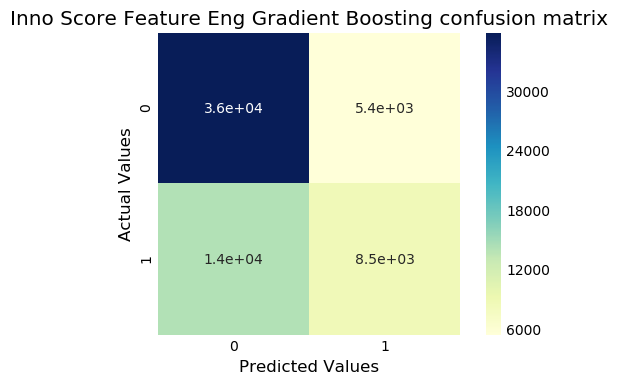

In [91]:
gbm = XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train_2,y_train_2),(X_test_2,y_test_2)]
fit_model = gbm.fit( 
                    X_train_2, y_train_2, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test_2, gbm.predict(X_test_2, ntree_limit=gbm.best_ntree_limit)) 

y_pred_xgb_2= gbm.predict(X_test_2)
confusion_xgb_2 = confusion_matrix(y_test_2, y_pred_xgb_2)
print(gbm.score(X_test_2, y_test_2))
print(roc_auc_score(y_test_2, y_pred_xgb_2))
plt.figure(dpi=100)
sns.heatmap(confusion_xgb_2, cmap=plt.cm.YlGnBu, annot=True, square=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Inno Score Feature Eng Gradient Boosting confusion matrix')

#### 3.1.3 Enumerate Feature Importance: do the numbers make sense?

The feature "goal" is ranked most important in constructing the xgboost model. One explanation could be that projects with more moderate goals have a better success rate. One method that can set a benchmark for how reasonable the goal of a project is set, see section 3.2 for second engineered feature. 

In [99]:
xgb_2_feature_importance = pd.DataFrame.from_dict(dict(zip(clean_binary_2.columns, gbm.feature_importances_)),
                                                  orient='index', columns=['importance']).reset_index()

xgb_2_feature_importance.sort_values(by='importance', ascending=False)

,index,importance
3,goal,0.280340
4,inno_score,0.276423
1,main_category,0.209361
0,category,0.154695
2,country,0.079181


In [91]:
clean_binary_2.to_csv('clean_binary2.csv')

#### 3.1.4 Logistic Regression round 2 

Results of this shows predicted 0 false positive (failed and predicted successful) and 0 true positive (successful and predicted successful). So all of these were getting predicted failed, giving it a 60% accuracy still since 60% of the dataset targets are failed projects. Lower threshold  so that model can capture with more accuracy the projects that have failed. 

/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6452572573826449
0.5525331912121256
0.3321586603428632
              precision    recall  f1-score   support

           0       0.66      0.79      0.72     41210
           1       0.42      0.28      0.33     22656

   micro avg       0.61      0.61      0.61     63866
   macro avg       0.54      0.53      0.53     63866
weighted avg       0.58      0.61      0.58     63866



Text(0.5, 1.0, '2nd Feature Eng Logistic regression confusion matrix')

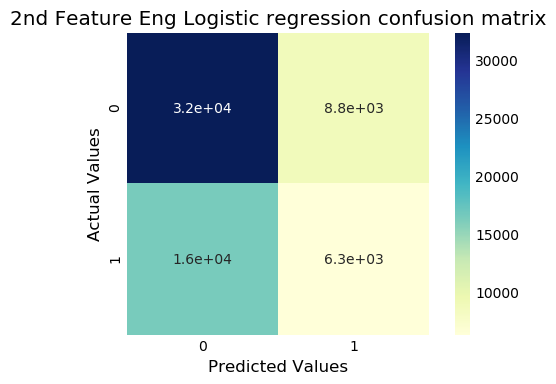

In [118]:
scaler=StandardScaler()

X_scaled_2 = scaler.fit_transform(X_train_2.values)
X_test_scaled_2 = scaler.fit_transform(X_test_2.values)

logreg_cv=LogisticRegressionCV()
logreg_cv.fit(X_scaled_2, y_train_2)
print(logreg_cv.score(X_test_scaled_2,y_test_2))

y_pred_log_2=logreg_cv.predict_proba(X_test_scaled_2)[:,1]
confusion_log_2=confusion_matrix(y_test_2, y_pred_log_2>0.38)



plt.figure(dpi=100)
sns.heatmap(confusion_log_2, cmap=plt.cm.YlGnBu, annot=True, square=True)
print(roc_auc_score(y_test_2, y_pred_log_2))
print(f1_score(y_test_2, y_pred_log_2>0.38))
print(classification_report(y_test_2, y_pred_log_2>0.40))

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('2nd Feature Eng Logistic regression confusion matrix')

### 3.2 Create "interest_score" and "goal_ratio".

#### 3.1.1 Create new columns of features.

Though we have eliminated the column "backers", this feature can still be used. Another element that contributes to the success of a campaign could be how much interest a project gauges. Interest - or demand - can be explored by looking at the total backers for a category. Put into scale, interest ratio can be defined by the total number of backers in a category divided by the total number of backers. 

Now let's look at the goals. It may be important for a project to properly set the goal amount in relation to which category it is in. A common way to measure how something compares to the rest of the population is the z-score, which is calculated through $z = (x - \mu )/ \sigma$. In this case, the goal of a project can be compared to the average goal for the category divided by the standard deviation. 


Now the question becomes, would measuring the interest score and goal score lead to better predictions?

    
  #### New Features:
* interest_score
* category_goal_score

In [44]:
# Make a copy of the original cleaned dataframe to restart, and add relevant engineered features.
clean_binary_312= clean_binary.copy()
clean_binary_312['inno_score']=clean_binary_2['inno_score']

# Drop pledged as that is an unknown when stakeholder trying to predict success or failure.
clean_binary_312=clean_binary_312.drop(columns=['pledged'])

# Create a new column for the average category goal called [category_goal].
# It's a good idea to gauge what the category goal is compared to the goal set by a project. 
average_goal_cat = clean_binary.groupby('category').mean().goal.to_dict()
stdv_goal_cat = clean_binary.groupby('category').std().goal.to_dict()
clean_binary_312['category_goal_mean']=clean_binary['category'].map(average_goal_cat)
clean_binary_312['category_stdv']=clean_binary['category'].map(stdv_goal_cat)

goal_z = lambda row: (row.goal - row.category_goal_mean)/(row.category_stdv)
clean_binary_312['goal_z'] = clean_binary_312.apply(goal_z, axis=1)


# Create a new column for the total amount of "interest" for a certain category calculated by total backers, called [interest_score].
interest_score = clean_binary.groupby('category').sum().backers.to_dict()
total_backers = np.sum(list(clean_binary.backers))
clean_binary_312['interest_score']=clean_binary['category'].map(interest_score)


# Then create a new column for a more normalized ratio of the interest score by dividing interest_score by the median interest_score,
# called [interest_ratio]. 
interest_ratio = lambda row: row.interest_score/total_backers*100
clean_binary_312['interest_ratio']=clean_binary_312.apply(interest_ratio, axis=1)

# Get rid of collinear columns, such as interest_score (it is now collinear with interest ratio)

clean_binary_312=clean_binary_312.drop(columns=['interest_score','backers','category_goal_mean','category_stdv'])

In [92]:
# Label Encode all categorical features and target

lec = LabelEncoder()
lem = LabelEncoder()
let = LabelEncoder()
lecat = LabelEncoder()
country=lec.fit_transform(clean_binary_312.country)
main_category=lem.fit_transform(clean_binary_312.main_category)
target= lem.fit_transform(clean_binary_312.state)
category=lecat.fit_transform(clean_binary_312.category)

clean_binary_312_label = clean_binary_312.copy()

clean_binary_312_label['country']=country
clean_binary_312_label['main_category']=main_category
clean_binary_312_label['state']=target
clean_binary_312_label['category']=category

# Rearrange columns and drop "name"

clean_binary_312_label = clean_binary_312_label[['category', 'main_category', 'country', 'inno_score', 'goal_z', 'interest_ratio','state']]

#### 3.2 Test the newly constructed features on top of previous features: did the model improve?

In [93]:
X3 = clean_binary_312_label.iloc[:, :-1]
y3 = clean_binary_312_label.iloc[:, -1:]

X_train_3, X_test_3, y_train_3, y_test_3= train_test_split(X3, y3, test_size=0.2, random_state=30)

/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array w

0.690398647167507
0.6127005775674271


Text(0.5, 1.0, '3nd Feature Eng Gradient Boosting confusion matrix')

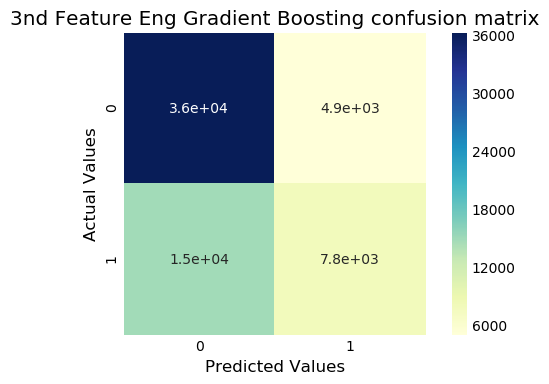

In [94]:
gbm_3 = XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train_3, y_train_3),(X_test_3,y_test_3)]
fit_model_3 = gbm_3.fit( 
                    X_train_3, y_train_3, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test_3, gbm_3.predict(X_test_3, ntree_limit=gbm_3.best_ntree_limit)) 

y_pred_xgb_3= gbm_3.predict(X_test_3)
confusion_xgb_3 = confusion_matrix(y_test_3, y_pred_xgb_3)
print(gbm_3.score(X_test_3, y_test_3))
print(roc_auc_score(y_test_3, y_pred_xgb_3))

plt.figure(dpi=100)
sns.heatmap(confusion_xgb_3, cmap=plt.cm.YlGnBu, annot=True, square=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('3nd Feature Eng Gradient Boosting confusion matrix')

In [96]:
print(classification_report(y_test_3, y_pred_xgb_3))

              precision    recall  f1-score   support

           0       0.71      0.88      0.79     41210
           1       0.61      0.35      0.44     22656

   micro avg       0.69      0.69      0.69     63866
   macro avg       0.66      0.61      0.61     63866
weighted avg       0.68      0.69      0.66     63866



In [95]:
#gbm_3.feature_importances_

xgb_3_feature_importance = pd.DataFrame.from_dict(dict(zip(clean_binary_312_label.columns, gbm_3.feature_importances_)),
                                                  orient='index', columns=['importance']).reset_index()

xgb_3_feature_importance.sort_values(by='importance', ascending=False)

,index,importance
3,inno_score,0.284655
1,main_category,0.267416
5,interest_ratio,0.127247
0,category,0.127043
4,goal_z,0.127034
2,country,0.066606


The metrics results are back in the 90% range, leading me to re-examine the features above. Since the engineered features are in-category ratios, there shouldn't be multilinearity with category names. Taking the result at face value, it is valuable to examine observations with high "interest_ratio". 

In [51]:
clean_binary_312.sort_values(by='interest_ratio', ascending=False)

,name,category,main_category,goal,state,country,inno_score,goal_z,interest_ratio
208996,LifeCool - Amazing lifesaving cooler for all b...,Product Design,Design,400000,failed,US,0.857143,0.912257,14.737349
248759,Sleepy Time Night Light (Canceled),Product Design,Design,50000,failed,US,0.857143,0.036080,14.737349
70495,360 SHELF: Adjustable shelf,Product Design,Design,15000,failed,US,0.857143,-0.051538,14.737349
220624,The MoBell Muscle Kit: A Portable Gym with a M...,Product Design,Design,75000,failed,US,0.857143,0.098664,14.737349
37283,Lego Star Wars Lightup Lightsabers,Product Design,Design,500,successful,US,0.857143,-0.087836,14.737349
248743,The Cave Carver: a hand tool for cutting and e...,Product Design,Design,11500,failed,US,0.857143,-0.060299,14.737349
129768,PopSwitch - Interchangeable pop up light switc...,Product Design,Design,5000,failed,US,0.857143,-0.076571,14.737349
70509,Venetian Lantern Installation,Product Design,Design,550,successful,US,0.857143,-0.087711,14.737349
198310,The Original Bathroom Multitool: Travel Made C...,Product Design,Design,10000,failed,US,0.857143,-0.064054,14.737349
88321,T-RAK Bike Cargo System,Product Design,Design,185000,failed,US,0.857143,0.374034,14.737349


### 3.3 Keyword Analysis

Numerical and categorical input can't always tell the whole story. Given the dataset at hand, the most informative column may be the name of the projects. By using text vectorization, I performed an analysis on importance of title names in correlation to target output. 

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

word_name_data = clean_binary[['name', 'category', 'state']]

corpus = list(word_name_data.name.values.astype('U'))
word_target=list(word_name_data.state.values.astype('U'))

le = LabelEncoder()
word_target=le.fit_transform(word_target)


vectorizer_f = TfidfVectorizer(stop_words = 'english', max_features=1000, decode_error = 'ignore')
vectorizer_t = TfidfVectorizer()
name_vectors = vectorizer_f.fit_transform(corpus)

# split into training and test data, and vectorize data
X_word_train, X_word_test, y_word_train, y_word_test = train_test_split(name_vectors, word_target)


idf = vectorizer_f.idf_
feature_names= vectorizer_f.get_feature_names()
word_importance = pd.DataFrame.from_dict(dict(zip(feature_names, idf)), orient='index', columns=['importance']).reset_index()

In [100]:
from scipy import sparse 

print('Fitting tf-idf to descriptions')

X_everything = sparse.hstack([name_vectors, # text features
                               X3.values], # normal features
                               format='csr')

Fitting tf-idf to descriptions


In [105]:
word_importance.to_csv('word_importance.csv')

In [69]:
X_train_f, X_test_f, y_train_f, y_test_f= train_test_split(X_everything, y3, test_size=0.2, random_state=30)

/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/carrieqiu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array w

0.716922932389691
0.6538119045330038


Text(0.5, 1.0, 'Combined Gradient Boosting confusion matrix')

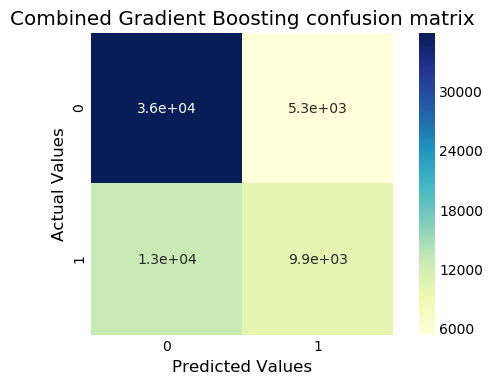

In [71]:
gbm_f = XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train_f, y_train_f),(X_test_f,y_test_f)]
fit_model_f = gbm_f.fit( 
                    X_train_f, y_train_f, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test_f, gbm_f.predict(X_test_f, ntree_limit=gbm_f.best_ntree_limit)) 

y_pred_xgb_f= gbm_f.predict(X_test_f)
confusion_xgb_f = confusion_matrix(y_test_f, y_pred_xgb_f)
print(gbm_f.score(X_test_f, y_test_f))
print(roc_auc_score(y_test_f, y_pred_xgb_f))
plt.figure(dpi=100)
sns.heatmap(confusion_xgb_f, cmap=plt.cm.YlGnBu, annot=True, square=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Combined Gradient Boosting confusion matrix')

In [107]:
print(classification_report(y_test_f, y_pred_xgb_f))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80     41210
           1       0.65      0.44      0.52     22656

   micro avg       0.72      0.72      0.72     63866
   macro avg       0.69      0.65      0.66     63866
weighted avg       0.71      0.72      0.70     63866



In [72]:
word_importance.sort_values(by='importance', ascending=False)

,index,importance
3,11,8.406119
165,chess,8.400978
247,desk,8.390773
176,circus,8.385710
595,murder,8.380672
809,socks,8.375660
90,belt,8.370672
87,bee,8.370672
501,lamp,8.370672
258,dock,8.365710


In [163]:
import re

word_chess = clean_binary[clean_binary['name'].str.contains("blind",na=False)]

In [164]:
word_chess

,name,category,main_category,goal,pledged,state,backers,country,Indexes
12267,Creeplings: spooky blind box collectible minia...,Product Design,Design,15000,15253,successful,209,US,-1.0
14786,Help Sunblind Go to Cannes,Documentary,Film & Video,8000,926,failed,21,US,-1.0
36398,blindeagle : world's first unbreakable chats a...,Hardware,Technology,90000,6649,failed,36,BE,-1.0
54012,"The Colorblind Perception, Portraits of the Co...",Conceptual Art,Art,1200,1213,successful,8,US,-1.0
55546,"original blues, blues, blind lemon, Blind Wil...",Blues,Music,10000,5,failed,1,CA,-1.0
71263,Picture book for the blind,Art Books,Publishing,50000,5,failed,1,US,-1.0
83840,Color blind message,Painting,Art,500,51,failed,4,US,-1.0
92267,COLORTHESIA - A Game Inspired by Colorblindness,Mobile Games,Games,1300,1350,successful,11,US,-1.0
108242,"Definitely A First's first full legnth album, ...",Rock,Music,2000,2100,successful,32,US,-1.0
108831,History is going blind! The Mardi Gras film pr...,Documentary,Film & Video,15500,512,failed,16,US,-1.0


In [162]:
clean_binary.groupby(['main_category','state']).count().sort_values(by=['state','name'], ascending=False)

,,name,category,goal,pledged,backers,country,Indexes
main_category,state,,,,,,,
Music,successful,21683,21683,21683,21683,21683,21683,21683
Film & Video,successful,21416,21416,21416,21416,21416,21416,21416
Publishing,successful,10277,10277,10277,10277,10277,10277,10277
Art,successful,9662,9662,9662,9662,9662,9662,9662
Games,successful,9427,9427,9427,9427,9427,9427,9427
Design,successful,8053,8053,8053,8053,8053,8053,8053
Theater,successful,5990,5990,5990,5990,5990,5990,5990
Food,successful,5264,5264,5264,5264,5264,5264,5264
Technology,successful,5153,5153,5153,5153,5153,5153,5153
